<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">


# Working with `Pandas`

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)

## Preamble

[Pandas](https://pandas.pydata.org) is part of nearly every data scientist's toolkit, with robust support for spreadsheet-like data structures. Until 2023, however, this workhorse of time series analysis was unusable in the paleogeosciences, because Pandas long ago hardcoded nanoseconds as the base unit of time. This limited the timescales it can represent on a 64-bit machine to a relatively narrow timespan of 585 years, thus excluding many paleogeoscience applications (for more explanations, see [this blog post](https://medium.com/cyberpaleo/pandas-and-the-geosciences-a-4-5-billion-year-story-66af9f565a4b)). In this notebook we explore the synergies between pandas and Pyleoclim.  

### Goals:
* Learn to export Pyleclim `Series` to Pandas `Series`.
* Unit conversions
* Select portions of a time series based on time or value criteria
* Export/Import to csv file
* Resampling in time
* Handling `MultipleSeries` with Pandas

### Reading time
10 minutes

### Keywords
Pandas; Time Units; Resampling in time; Selection

### Pre-Requisites
Knoweldge of Pyleoclim `Series` and `MultipleSeries` objects. Familiarity with Pandas. 

### Relevant Packages

Pandas

## Data Description

* Sea-surface temperature from Kaplan (1998) averaged over the NINO3 (5N-5S, 150W-190E)) region.
* Bereiter, B., Eggleston, S., Schmitt, J., Nehrbass-Ahles, C., Stocker, T. F., Fischer, H., … Chappellaz, J. (2015). Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present. Geophysical Research Letters, 42(2), 542–549. doi:10.1002/2014gl061957

## Demonstration

In [1]:
%load_ext watermark
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyleoclim as pyleo

Let us load the SOI timeseries:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year C.E.]', ylabel='SOI [mb]'>)

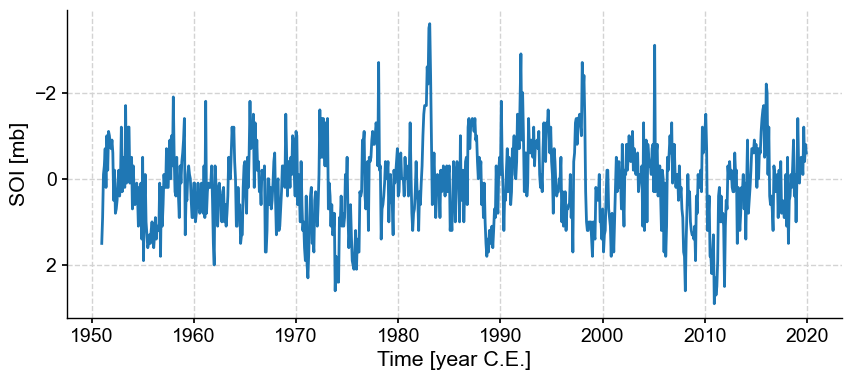

In [2]:
ts = pyleo.utils.load_dataset('SOI')
ts.plot(invert_yaxis=True) # invert y axis so El Niño events plot upward

There are two properties attached to `pyleo.Series` objects:
1. a Pandas [datetime_index](https://pandas.pydata.org/docs/dev/reference/api/pandas.DatetimeIndex.html):

In [3]:
ts.datetime_index

DatetimeIndex(['1950-12-31 12:42:56', '1951-01-30 23:11:49',
               '1951-03-02 09:41:14', '1951-04-01 20:10:07',
               '1951-05-02 06:39:01', '1951-06-01 17:08:26',
               '1951-07-02 03:37:19', '1951-08-01 14:06:12',
               '1951-09-01 00:35:37', '1951-10-01 11:04:30',
               ...
               '2019-03-01 20:57:20', '2019-04-01 07:26:14',
               '2019-05-01 17:55:07', '2019-06-01 04:24:32',
               '2019-07-01 14:53:25', '2019-08-01 01:22:19',
               '2019-08-31 11:51:43', '2019-09-30 22:20:37',
               '2019-10-31 08:49:30', '2019-11-30 19:18:55'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

2. a dictionary bundling all the metadata:

In [4]:
ts.metadata

{'time_unit': 'year C.E.',
 'time_name': 'Time',
 'value_unit': 'mb',
 'value_name': 'SOI',
 'label': 'Southern Oscillation Index',
 'archiveType': 'Instrumental',
 'importedFrom': None,
 'log': None}

Invoking the object itself returns some essential metadata and a compressed view of the data.

In [5]:
ts

{'archiveType': 'Instrumental', 'label': 'Southern Oscillation Index'}


None
Time [year C.E.]
1951.000000    1.5
1951.083333    0.9
1951.166667   -0.1
1951.250000   -0.3
1951.333333   -0.7
              ... 
2019.583333   -0.1
2019.666667   -1.2
2019.750000   -0.4
2019.833333   -0.8
2019.916667   -0.6
Name: SOI [mb], Length: 828, dtype: float64

For a prettier display (in Jupyter notebook only):

In [6]:
ts.view()

,SOI [mb]
Time [year C.E.],
1951.000000,1.5
1951.083333,0.9
1951.166667,-0.1
1951.250000,-0.3
1951.333333,-0.7
...,...
2019.583333,-0.1
2019.666667,-1.2
2019.750000,-0.4


### .to_pandas()

It is easy to export a Pyleoclim Series to a Pandas Series:

In [7]:
pdts = ts.to_pandas() #  returns just the Series ; metadata are available at ts.metadata
type(pdts) 

pandas.core.series.Series

It is now a bona fide Pandas Series, and we can do with it everything we might do with Pandas. For example:

In [8]:
pdts.head()

datetime
1950-12-31 12:42:56    1.5
1951-01-30 23:11:49    0.9
1951-03-02 09:41:14   -0.1
1951-04-01 20:10:07   -0.3
1951-05-02 06:39:01   -0.7
Name: SOI, dtype: float64

Or this:

In [9]:
pdts.describe()

count    828.000000
mean       0.119928
std        0.938586
min       -3.600000
25%       -0.500000
50%        0.100000
75%        0.800000
max        2.900000
Name: SOI, dtype: float64

Because Pyleoclim now has Pandas under the hood, one can now apply any Pandas method to a Pyleoclim Series, via a [lambda function](https://www.freecodecamp.org/news/python-lambda-function-explained/). For instance, applying an exponential transform to the data:

In [10]:
ts.pandas_method(lambda x: x.transform(np.exp))

{'archiveType': 'Instrumental', 'label': 'Southern Oscillation Index'}


None
Time [year C.E.]
1951.000000    4.481689
1951.083333    2.459603
1951.166667    0.904837
1951.250000    0.740818
1951.333333    0.496585
                 ...   
2019.583333    0.904837
2019.666667    0.301194
2019.750000    0.670320
2019.833333    0.449329
2019.916667    0.548812
Name: SOI [mb], Length: 828, dtype: float64

For more examples, see [this page](https://sparkbyexamples.com/pandas/pandas-apply-with-lambda-examples/?utm_content=expand_article)

### Unit conversions

Pyleoclim now comprehends datestring semantics, which enable enhanced conversions betwen time representations. For instance, converting the SOI series to years before 1950 ("BP"): 

### Selection

Let's load a true paleoclimate example, the Dome C $CO_2$ [composite](https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt), and use Pandas semantics to select particular values.

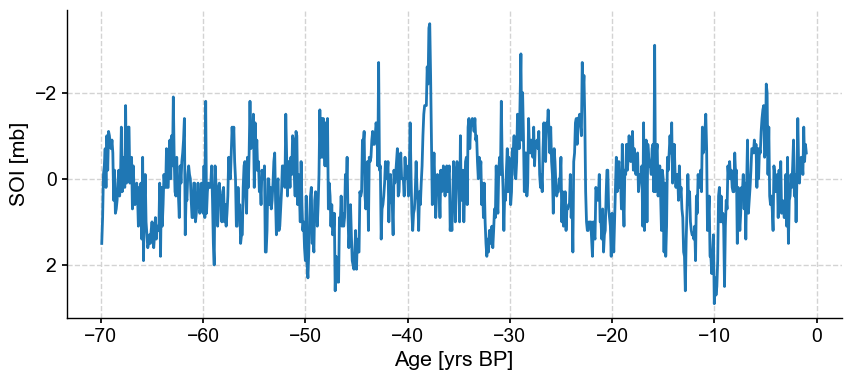

In [11]:
tsBP = ts.convert_time_unit('yrs BP')  
fig, ax = tsBP.plot(invert_yaxis=True) # by default, plots represent values in increasing order, so we reverse the x-axis

The Series plots from recent to old, because the Matplotlib `plot()` function always works with increasing values. However, it is easy to check that it was indeed flipped:

In [12]:
tsBP.view()

,SOI [mb]
Age [yrs BP],
-69.914717,1.5
-69.831383,0.9
-69.748050,-0.1
-69.664717,-0.3
-69.581383,-0.7
...,...
-1.331383,-0.1
-1.248050,-1.2
-1.164717,-0.4


The index has been flipped as well:

In [13]:
tsBP.datetime_index

DatetimeIndex(['2019-11-30 19:18:55', '2019-10-31 08:49:30',
               '2019-09-30 22:20:37', '2019-08-31 11:51:43',
               '2019-08-01 01:22:19', '2019-07-01 14:53:25',
               '2019-06-01 04:24:32', '2019-05-01 17:55:07',
               '2019-04-01 07:26:14', '2019-03-01 20:57:20',
               ...
               '1951-10-01 11:04:30', '1951-09-01 00:35:37',
               '1951-08-01 14:06:12', '1951-07-02 03:37:19',
               '1951-06-01 17:08:26', '1951-05-02 06:39:01',
               '1951-04-01 20:10:07', '1951-03-02 09:41:14',
               '1951-01-30 23:11:49', '1950-12-31 12:42:56'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

If we wanted to preserve the original time flow (old to recent) in a plot, all you'd have to do is use the `invert_xaxis` parameter:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yrs BP]', ylabel='SOI [mb]'>)

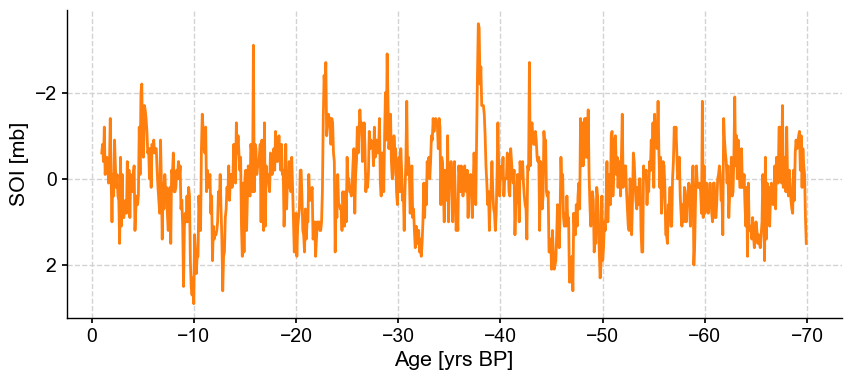

In [14]:
tsBP.plot(invert_yaxis=True, invert_xaxis=True, label = 'SOI, years BP', color='C1') 

(this is an admittedly contrived example, as no one in their right mind would cast instrumental series in years BP). 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

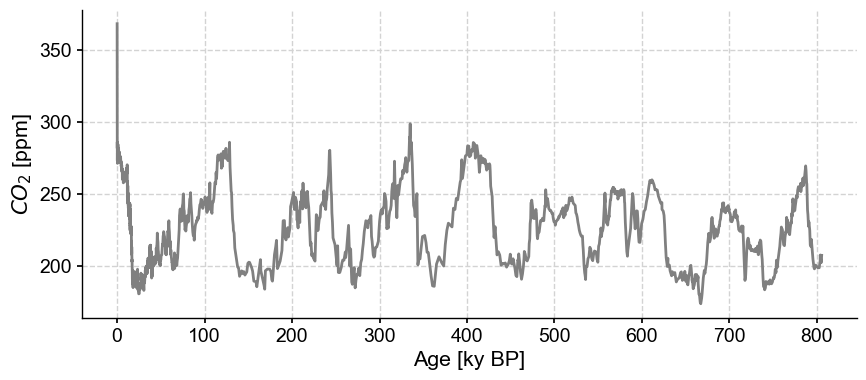

In [15]:
co2ts = pyleo.utils.load_dataset('AACO2')
co2ts.plot(color='gray')

In [16]:
co2ts.metadata

{'time_unit': 'ky BP',
 'time_name': 'Age',
 'value_unit': 'ppm',
 'value_name': '$CO_2$',
 'label': 'EPICA Dome C CO2',
 'archiveType': 'GlacierIce',
 'importedFrom': 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt',
 'log': None}

In [17]:
co2ts.view()

,$CO_2$ [ppm]
Age [ky BP],
-0.05103,368.02
-0.04800,361.78
-0.04628,359.65
-0.04441,357.11
-0.04308,353.95
...,...
803.92528,202.92
804.00987,207.50
804.52267,204.86


To select a particular interval, (say the [Eemian](https://en.wikipedia.org/wiki/Eemian), 115 to 130 ky BP), you can use `sel`:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

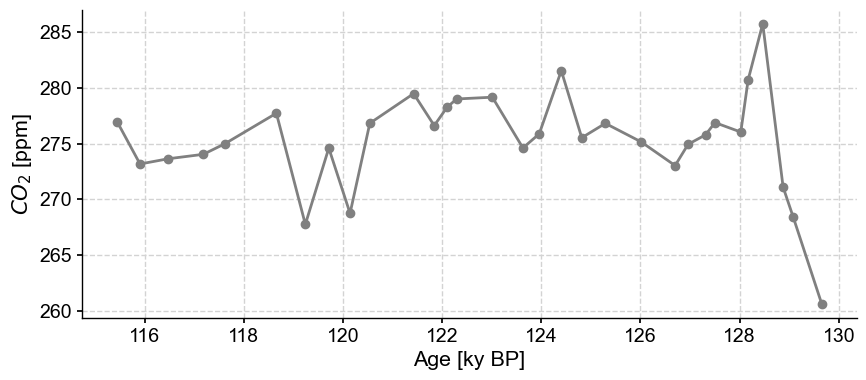

In [18]:
co2_ee = co2ts.sel(time=slice(115,130))
co2_ee.plot(marker='o', color='gray')

If you wanted to extract the time of the maximum value, an easy approach is to use `sel` again:

In [19]:
co2_ee.sel(value=co2_ee.value.max()).view()

,$CO_2$ [ppm]
Age [ky BP],
128.46673,285.76


We zero-ed in on the value ~128.5 ky BP as the highest $CO_2$ concentration in the Eemian. Note that the result is still a `Series` object (in this case, a very short one!).  Similarly, to identify the timing of glacial maxima by values below 200 ppm, one could select with an open interval:

<Axes: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

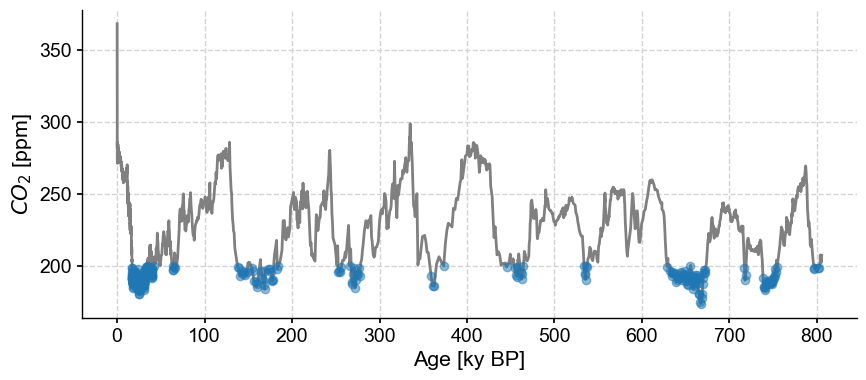

In [20]:
co2_G = co2ts.sel(value=slice(None,200)) # returns a new Series object
fig, ax = co2ts.plot(color='gray')
co2_G.plot(marker='o',linewidth=0,alpha= 0.5, ax=ax,label=r"$CO_2\leq200$") 

For interglacials, select half-open intervals the other way:

<Axes: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

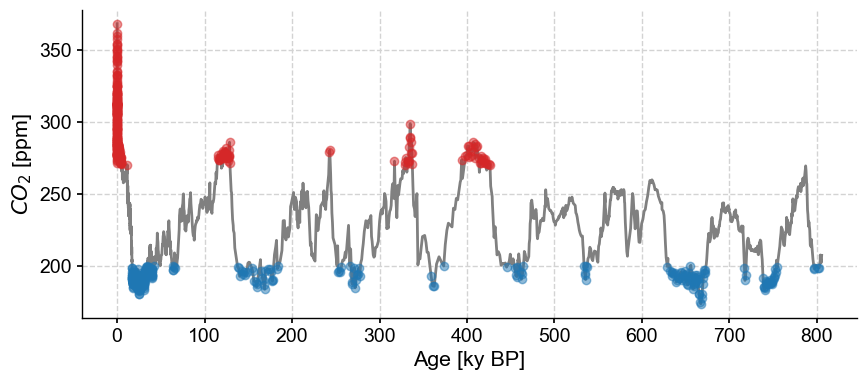

In [21]:
co2_IG = co2ts.sel(value=slice(270,None)) # returns a new Series object
fig, ax = co2ts.plot(color='gray')
co2_G.plot(marker='o',linewidth=0,alpha= 0.5, ax=ax,label=r"$CO_2\leq200$") 
co2_IG.plot(marker='o',linewidth=0, color = 'C3', alpha= 0.5, ax=ax,label=r"$CO_2\geq270$") 

Again, both of these are `Series` objects, albeit highly discontinuous ones. 

Science Remark: admittedly, an absolute threshold for defining interglacials makes little sense. A smarter way would be to use [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), as implemented in the `outliers()` method and a [dedicated tutorial](./L2_outlier_detection.md). 

### CSV Import/Export

Pandas integration allows a very easy round trip with CSV files:

#### Exporting to CSV

In [22]:
filename = '../data/EPICA_Dome_C_CO2.csv'
co2ts.to_csv(path = filename)

Series exported to ../data/EPICA_Dome_C_CO2.csv


The path name is optional; if no file name is provided (as is the case here), the file is named after the `Series` label. This is another reason to choose meaningful and relatively concise labels!

#### Importing from CSV
Read the file back in and gives the same `Series`:

In [23]:
co2ts2 = pyleo.Series.from_csv(path='../data/EPICA_Dome_C_CO2.csv')
co2ts2.equals(co2ts) 

Time axis values sorted in ascending order


/Users/deborahkhider/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:512: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  return cls(time=df.iloc[:,0],value=df.iloc[:,1], **metadata)


(True, True)

Note the use of the `equals()` method, inspired the [eponymous method from Pandas](https://pandas.pydata.org/docs/reference/api/pandas.Series.equals.html). The Pyleoclim implementation returns two boolean objects: the first says whether the two Pandas `Series` are the same; the second whether the metadata are the same. Fortunately, we landed back on our feet. 

### Resampling

One of Pandas' most powerful capabilities is [resampling()](https://pandas.pydata.org/docs/user_guide/timeseries.html#resampling) series to attain various temporal resolutions. Pyleoclim implements a function of the same name, but using normal "paleo-speak" to define resolution. For instance, let's coarse-grain on 5,000 year intervals:

In [24]:
co2_5k = co2ts.resample('5ka')
type(co2_5k)

pyleoclim.core.series.SeriesResampler

The output of this function is a variant on a Pandas [resampler](https://pandas.pydata.org/docs/reference/resampling.html); the values then need to be aggregated or transformed. For our purpose, let's average them over those 5ky bins:

<Axes: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

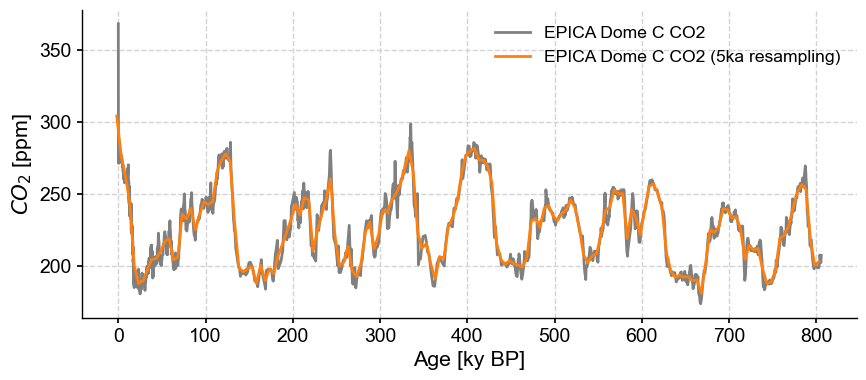

In [25]:
co2_5kavg = co2_5k.mean() # the aggregator here is simply the mean
fig, ax = co2ts.plot(color='gray')
co2_5kavg.plot(ax=ax,color='C1')         

One notable distinction to standard Pandas resampling is that Pyleoclim aligns the resampled index to the _midpoint_ of each interval, to minimize age offsets. In contrast, Pandas aligns to the beginning of an interval.  

In terms of nomenclature, `resample()` can understand several abbreviations for "kiloyear", such as 'ka', 'ky', or 'kyrs'. In fact, these would work:

In [26]:
pyleo.utils.tsbase.MATCH_KA

frozenset({'ka', 'kiloyear', 'kiloyr', 'kiloyrs', 'ky', 'kyr', 'kyrs'})

For millions of years, use:

In [27]:
pyleo.utils.tsbase.MATCH_MA

frozenset({'ma', 'my', 'myr', 'myrs'})

and so on for other multiples, like years (`pyleo.utils.tsbase.MATCH_A`) or billion years (`pyleo.utils.tsbase.MATCH_GA`) 


Further, the `Resampler` class allows one to choose statistics other than the mean, e.g., a running standard deviation:

In [28]:
co2_5k.std().view()

ValueError: Values falls before first bin

### Pandas operations with MultipleSeries objects

Let's load the Deuterium EPICA DOME C record:

In [29]:
edc = pyleo.utils.load_dataset('EDC-dD')

We then create a `MultipleSeries` object using the `&` shorthand:

In [30]:
ms =  edc.convert_time_unit("ky BP") & co2ts
type(ms)

pyleoclim.core.multipleseries.MultipleSeries

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='$\\delta \\mathrm{D}$ [‰]'>,
  1: <Axes: ylabel='$CO_2$ [ppm]'>,
  'x_axis': <Axes: xlabel='Age [ka]'>})

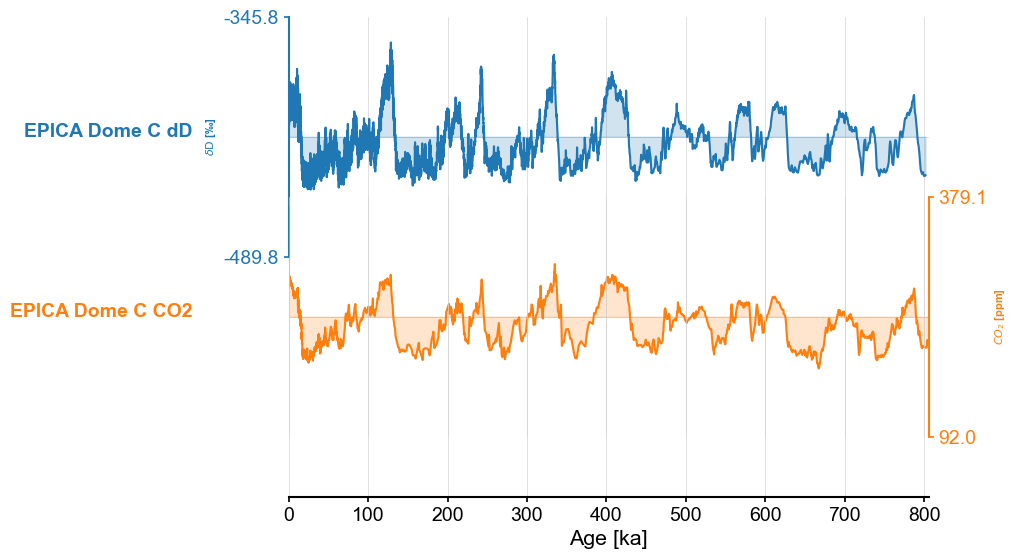

In [31]:
ms.stackplot()

#### Exporting to pandas

The `MultipleSeries` class also has a `to_pandas()` method; this one exports to a dataframe:

In [32]:
df = ms.to_pandas()
df.head()

,EPICA Dome C dD,EPICA Dome C CO2
datetime,,
-803719-10-17 10:22:57,NaN,207.29
-803182-03-23 07:19:38,NaN,202.23
-802573-12-30 00:58:49,NaN,204.86
-802060-10-17 05:46:09,NaN,207.50
-801975-05-20 01:52:17,NaN,202.92


By default, `to_pandas()` exports the `Series` as they are, and one can see that the values are not aligned. Some plotting functions still work out of the proverbial box:

array([[<Axes: title={'center': 'EPICA Dome C dD'}>,
        <Axes: title={'center': 'EPICA Dome C CO2'}>]], dtype=object)

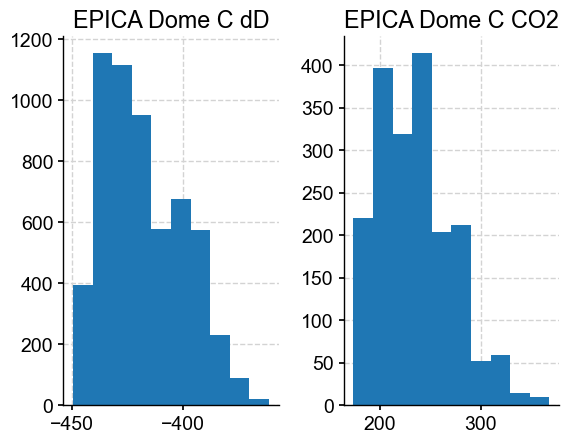

In [33]:
df.hist()

Alas, `df.plot()` wouldn't work, as Matplotlib assumes dates must be between year 0001 and 9999. 

As with `Series`, `ms.to_csv()` will export the object to a CSV file. We skip this here, as the output is not very graphical. 

#### Aligning to a common axis
In many instances it is useful for the `Series` to share a common time axis. This can be done simply this way:

In [34]:
df = ms.to_pandas(use_common_time=True)
df.head()

,EPICA Dome C dD,EPICA Dome C CO2
datetime,,
1911-08-18 06:32:30,-390.900000,299.817617
1630-04-19 08:12:23,-400.382865,274.220786
1348-12-20 09:52:15,-401.167982,278.367365
1067-08-23 11:32:07,-398.662864,282.612398
786-04-25 13:11:59,-396.520050,279.625252


Seaborn is a plotting library designed to visualize DataFrames. With just one line, it is easy to get an overview of the data with a [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html):

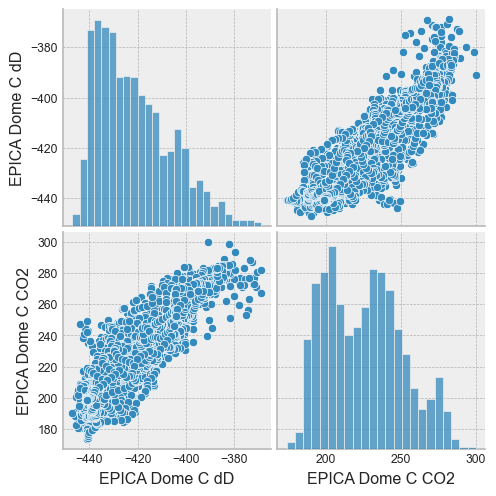

In [35]:
sns.set(font_scale=0.8)
with plt.style.context('bmh'):
    sns.pairplot(df)  

or a [`jointplot`](https://seaborn.pydata.org/generated/seaborn.jointplot.html?highlight=jointplot#seaborn.jointplot):

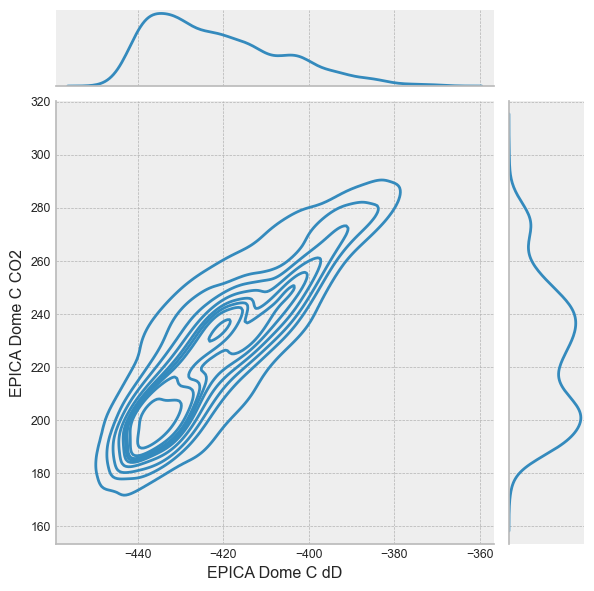

In [36]:
with plt.style.context('bmh'):
    sns.jointplot(data=df,kind='kde', x='EPICA Dome C dD', y='EPICA Dome C CO2')  

### Summary
The legendary pandas library is now fully integrated within Pyleoclim. This opens the door to many powerful, user-friendly functionatlities for data processing and visualization. For other examples of how pandas is making life easier in Pyleoclim, see [this notebook](L0_basic_ts_manipulation.md); however, the real frontier is what you will decide to do with it. Possibilities abound!

In [3]:
%watermark -n -u -v -iv -w

Last updated: Tue Jun 11 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.1.4
matplotlib: 3.8.0
pyleoclim : 1.0.0

Watermark: 2.4.3

